In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Load Visualisation Plugin
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set()

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")


# Data Preprocessing

In [69]:
# Import CSV
Customer_df=pd.read_csv("kaggle/Customer Acqusition.csv")
Repayment_df=pd.read_csv("kaggle/Repayment.csv")
Spend_df=pd.read_csv("kaggle/spend.csv")

# Make a Copy
Customer_copy=Customer_df.copy()
Repayment_copy=Repayment_df.copy()
Spend_copy=Spend_df.copy()

In [70]:
## Checking for missing data
# Customer_copy.isnull().sum()
# Repayment_copy.isnull().sum() - Missing Data
# Spend_copy.isnull().sum()
# Customer_copy.describe(include='all')

In [4]:
# Drop unnecessary columns, Correct the SL_No:, Drop NAN Rows, rename Repayment Columns Name
Repayment_copy = Repayment_copy.drop(labels='Unnamed: 4', axis=1)
Repayment_copy['SL No:'] = Repayment_copy.index+1
Repayment_copy = Repayment_copy.dropna()
Repayment_copy = Repayment_copy.rename(columns={"Month":"Repay_Date","Amount":"Repay_Amt","SL No:":"SL_No:"})
Repayment_copy['Repay_Date']=pd.to_datetime(Repayment_copy['Repay_Date'], format='%d-%b-%y', errors='ignore')
# Repayment_copy['Repay_Month_Year'] = Repayment_copy['Repay_Date'].dt.to_period('M')


## Correct the spelling in Cus_df
Customer_copy = Customer_copy.rename(columns={"Product":"Tier"})
Customer_copy['Tier'] = Customer_copy['Tier'].replace('Platimum', 'Platinum')
Customer_copy = Customer_copy.rename(columns={"Limit":"Credit_Limit"})


## Correct the spelling, edit columns names and get date(month and years)
Spend_copy['Type']= Spend_copy['Type'].replace('PETRO','PETROL')
Spend_copy = Spend_copy.rename(columns={"Month":"Purchase_Date","Amount":"Spend_Amt","Sl No:":"SL_No:"})
Spend_copy['Purchase_Date']=pd.to_datetime(Spend_copy['Purchase_Date'], format='%d-%b-%y', errors='ignore')
# Spend_copy['Purchase_Month_Year'] = Spend_copy['Purchase_Date'].dt.to_period('M')


In [5]:
#Function to categorize AgeGroup

# Create Age Group for Customer
def agegroup (age):
    if age < 20:
        return 'Teenager'
    elif age >=20 and age <60:
        return 'Adult'
    elif age >= 60:
        return 'OlderAdult'
    
# Credit Score Calculation    
def credit_model(row):
    # Initialize risk score
    credit_score = 0
    
    # Payment history
    if row['Repaid']:
        #true
        credit_score += 1
    else:
        #false
        credit_score -= 1
    
    # Credit Spent within their Limit
    limit_utilization = row['sum_Spend_Amt'] / row['max_Credit_Limit']
    if limit_utilization < 1:
        credit_score += 1
    elif limit_utilization > 1:
        credit_score -= 1
    
    return credit_score   
 
# Total Month to Years and Months    
def months_to_years_months(months):
    years = months // 12
    remaining_months = months % 12
    return f"{years} years and {remaining_months} months"  

def custom_colname(col):
    # If there's an aggregation (like 'count', 'max', 'sum', etc.), join them in the format you described.
    if col[1]:
        return f"{col[1]}_{col[0]}"
    # If not, just return the original column name.
    else:
        return col[0]
    
Customer_copy['AgeGroup'] = Customer_copy['Age'].apply(agegroup)


In [6]:
Repayment_copy.head(5)

SL_No: Customer Repay_Date  Repay_Amt
0       1       A1 2004-01-12  495414.75
1       2       A1 2004-01-03  245899.02
2       3       A1 2004-01-15  259490.06
3       4       A1 2004-01-25  437555.12
4       5       A1 2005-01-17  165972.88

In [7]:
# Customer merge with Spend df

Customer_Spend_Merged = pd.merge(Customer_copy,Spend_copy,on=['Customer'],how='inner')
Customer_Spend_Merged.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Credit_Limit', 'Company',
       'Segment', 'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt'],
      dtype='object')

In [8]:
# All Merged

All_Merged = pd.merge(Customer_Spend_Merged,Repayment_copy,on=['Customer','SL_No:'],how='inner')
# All_Merged.dtypes

In [9]:

All_Merged['Repay_Date'] = All_Merged['Repay_Date'].astype(str)
All_Merged['Purchase_Date'] = All_Merged['Purchase_Date'].astype(str)

mask = All_Merged['Repay_Date'] < All_Merged['Purchase_Date']
All_Merged.loc[mask, ['Repay_Date', 'Purchase_Date']] = All_Merged.loc[mask, ['Purchase_Date', 'Repay_Date']].values


All_Merged['Purchase_Date'] = pd.to_datetime(All_Merged['Purchase_Date'])
All_Merged['Repay_Date'] = pd.to_datetime(All_Merged['Repay_Date'])


All_Merged['Purchase_Month_Year'] = All_Merged['Purchase_Date'].dt.to_period('M')
All_Merged['Repay_Month_Year'] = All_Merged['Repay_Date'].dt.to_period('M')

# suspected_rows2= All_Merged.loc[mask]
# suspected_rows2

# mask2 = All_Merged['Repay_Date'] > All_Merged['Purchase_Date']

# All_Merged.loc[mask]
# All_Merged.loc[All_Merged['Repay_Date'] >= All_Merged['Purchase_Date']]
All_Merged.loc[(All_Merged['AgeGroup'] == 'Teenager') & (All_Merged['Tier'] == 'Silver')]


No Customer  Age        City    Tier  Credit_Limit Company  \
1463  68      A68   12  TRIVANDRUM  Silver      100000.0     C30   
1464  68      A68   12  TRIVANDRUM  Silver      100000.0     C30   

            Segment  AgeGroup  SL_No: Purchase_Date        Type  Spend_Amt  \
1463  Self Employed  Teenager      70    2004-01-25    SHOPPING    9665.48   
1464  Self Employed  Teenager    1497    2006-03-25  BUS TICKET  204971.10   

     Repay_Date  Repay_Amt Purchase_Month_Year Repay_Month_Year  
1463 2004-01-25  105098.26             2004-01          2004-01  
1464 2006-05-10  319836.49             2006-03          2006-05

<h2>Cilent Composition</h2>

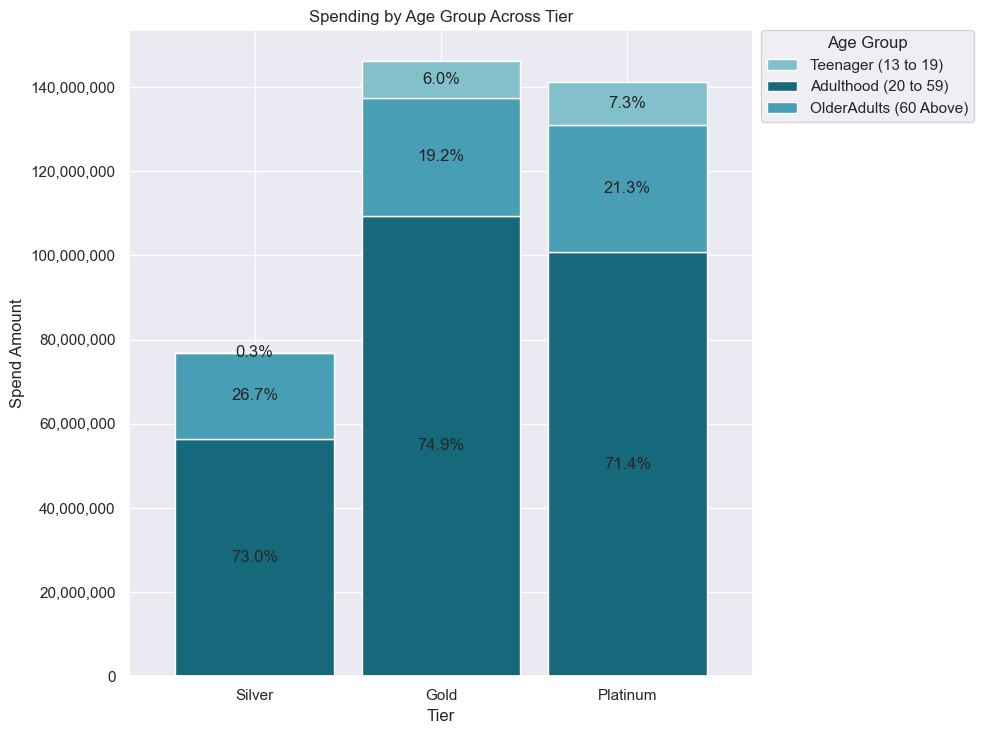

In [10]:
## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
Cust_Spend_GrpBy_Age_Tier = Customer_Spend_Merged.groupby(['AgeGroup','Tier'])['Spend_Amt'].sum().reset_index()


stack_color_palette=['#16697a','#489fb5','#82c0cc']
pivot_data = Cust_Spend_GrpBy_Age_Tier.pivot(index='Tier', columns='AgeGroup', values='Spend_Amt')

ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar',stacked=True,figsize=(10,7.5),color=stack_color_palette, width=0.85)

# Set the order of x-axis ticks
preferred_order_tier = ['Silver', 'Gold', 'Platinum']


# Set x and y labels
plt.xlabel('Tier')
plt.xticks(rotation=0)
ax.set_xticklabels(preferred_order_tier)

plt.ylabel('Spend Amount')
# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)


# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adult', 'OlderAdult']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))


# Rename legends and adjust position
labels = ['Teenager (13 to 19)', 'Adulthood (20 to 59)', 'OlderAdults (60 Above)']
ax.legend(handles, labels, title='Age Group', loc='upper left', bbox_to_anchor=(1, 1.0125))

# Annotate the bars
for idx, label in enumerate(preferred_order_tier):
    total = pivot_data.loc[label].sum()  # total amount for this tier
    y_offset = 0  # To keep track of where to put text in the y-axis
    for col in pivot_data.columns:
        value = pivot_data.loc[label, col]
        if value == 0:  # Skip zero values
            continue
        percentage = (value / total) * 100  # Calculate the percentage
        y_pos = y_offset + (value / 2)  # Position to place text in y-axis
        ax.text(idx, y_pos, f"{percentage:.1f}%", ha='center', va='center')
        y_offset += value # Increase the y_offset for next iteration


plt.title('Spending by Age Group Across Tier')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


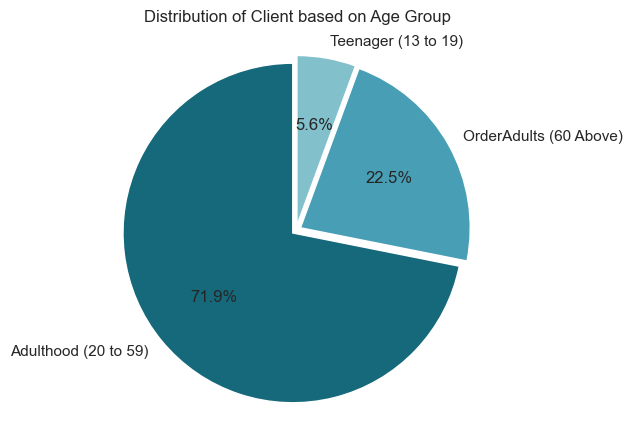

In [11]:
Count_AgeGroup = Customer_Spend_Merged['AgeGroup'].value_counts()
Count_AgeGroup_Labels = ['Adulthood (20 to 59)','OrderAdults (60 Above)','Teenager (13 to 19)']

# Only "explode" the 2nd slice
explode = (0.025, 0.03, 0.03)

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_AgeGroup, labels=Count_AgeGroup_Labels, autopct='%1.1f%%', startangle=90 ,colors=stack_color_palette, explode=explode)
plt.title('Distribution of Cilent based on agegroup')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Client based on Age Group', y=1.02)  # Adjust the y parameter to move the title up
plt.axis('equal')

# Show the plot
plt.show()

<h2> Geographic distribution </h2>

In [12]:
CS_Groupby_City_Tier = Customer_Spend_Merged.groupby(['City','Tier']).size().reset_index(name='No')


Tree_fig = px.treemap(CS_Groupby_City_Tier,path=['City'],values='No')

# Update hover template for formatting
Tree_fig.update_traces(
    texttemplate='<b>%{label}</b><br>Population:%{value:}',
    textfont=dict(
        size=13,
        color="#050505"
    )
)

# Update layout for better visualization
Tree_fig.update_layout(
    title="Geographic Distribution by Density",
    plot_bgcolor='white',
    margin=dict(l=0, r=0, t=20, b=20),
    title_x=0.5,
    title_y=0.95,
    hovermode=False
)

# Show the plot
Tree_fig.show()

## Categories with the most spending

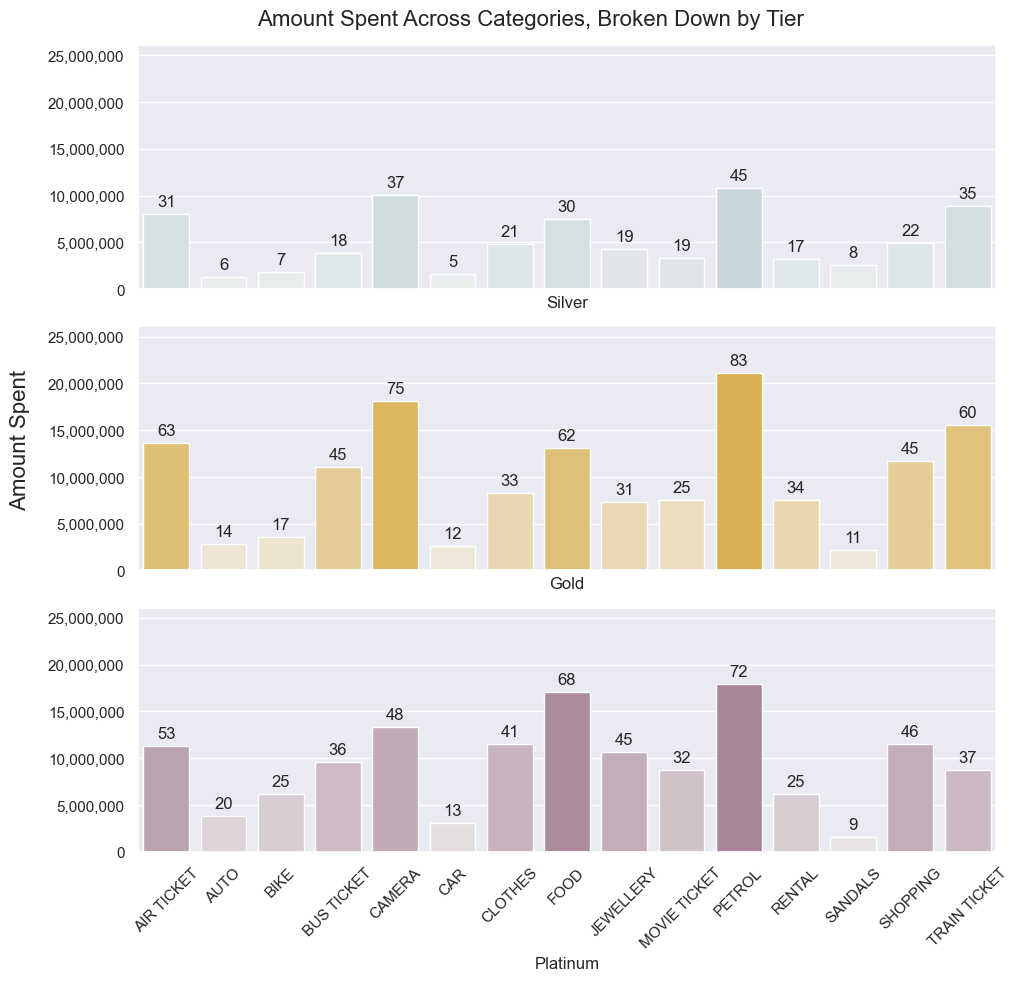

In [13]:
Categories_agg_funcs = {
    'Spend_Amt': ['sum','mean'],
    'Type':['count']
}

Categories_df = Customer_Spend_Merged.groupby(['Tier', 'Type']).agg(Categories_agg_funcs).reset_index()
Categories_df.columns =  [custom_colname(col) for col in Categories_df.columns]

Filtered_Teir_ax1 = Categories_df[Categories_df['Tier'] == 'Silver']
Filtered_Teir_ax2 = Categories_df[Categories_df['Tier'] == 'Gold']
Filtered_Teir_ax3 = Categories_df[Categories_df['Tier'] == 'Platinum']

teir_figure,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)

AxisY_count = Filtered_Teir_ax2['count_Type'].max()

# Create the Seaborn color palette
grad_color_s = sns.light_palette("#A4C7CE", reverse=False, as_cmap=True)
grad_color_g = sns.light_palette("#F0B93A", reverse=False, as_cmap=True)
grad_color_p = sns.light_palette("#A2708A", reverse=False, as_cmap=True)


# Normalize the 'Count' data and map to the color palette
palette_s = [grad_color_s(count/AxisY_count) for count in Filtered_Teir_ax1['count_Type']]
palette_g = [grad_color_g(count/AxisY_count) for count in Filtered_Teir_ax2['count_Type']]
palette_p = [grad_color_p(count/AxisY_count) for count in Filtered_Teir_ax3['count_Type']]

sns.barplot(data=Filtered_Teir_ax1, x='Type', y='sum_Spend_Amt',palette=palette_s,ax=ax1)
ax1.set_ylabel("Silver")

sns.barplot(data=Filtered_Teir_ax2, x='Type', y='sum_Spend_Amt',palette=palette_g,ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=Filtered_Teir_ax3, x='Type', y='sum_Spend_Amt',palette=palette_p,ax=ax3)
ax3.set_ylabel("Platinum")

# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)

Spend_Amt_Spacing = 5000000
ax1.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)
ax2.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)
ax3.set_ylim(0, Categories_df['sum_Spend_Amt'].max()+Spend_Amt_Spacing)

ax1.set(ylabel=None,xlabel='Silver')
ax2.set(ylabel=None,xlabel='Gold')
ax3.set(ylabel=None,xlabel='Platinum')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility


def annotate_bars(ax, data):
    for i, p in enumerate(ax.patches):
        count = data.iloc[i]['count_Type']
        ax.annotate(format(count, '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1, Filtered_Teir_ax1)
annotate_bars(ax2, Filtered_Teir_ax2)
annotate_bars(ax3, Filtered_Teir_ax3)


# Finalize the plot
teir_figure.suptitle('Amount Spent Across Categories, Broken Down by Tier', fontsize=16)
teir_figure.text(-0.02, 0.55, 'Amount Spent', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(h_pad=1)
plt.show()


In [14]:
# Customer_Spend_Merged

In [15]:
# Cust_Spend_GrpBy_Type
# condition = (Customer_Spend_Merged['Tier'] == 'Gold') & (Customer_Spend_Merged['Type'] == 'PETROL')
# filtered_df = Customer_Spend_Merged.loc[condition]
# filtered_df['Spend_Amt'].sum()


In [16]:
# condition = (Cust_Spend_GrpBy_Type['Tier'] == 'Gold') & (Cust_Spend_GrpBy_Type['Type'] == 'PETROL')
# filtered_df = Cust_Spend_GrpBy_Type.loc[condition]
# filtered_df['Spend_Amt'].sum()


In [17]:
# Cust_Spend_GrpBy_Type

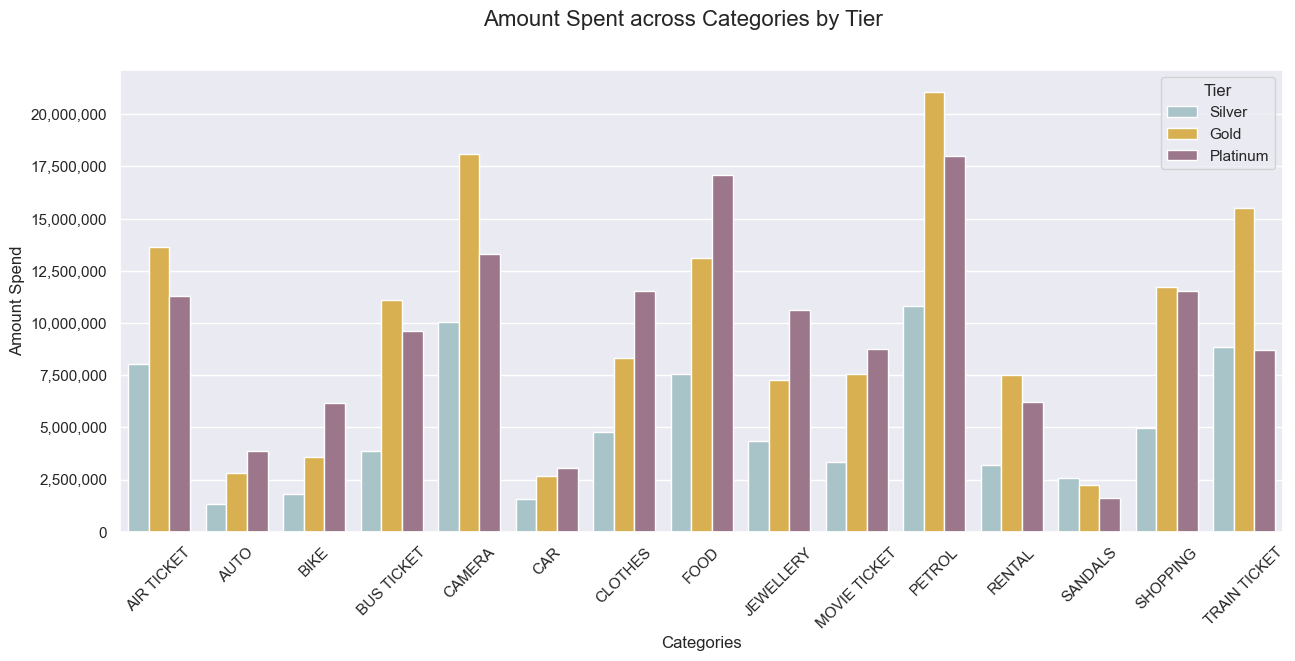

In [18]:
GrpBy_TierType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max'],
#     'Customer':['max']
}

colors = ['#A4C7CE','#F0B93A','#A2708A']


## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_TierType = Customer_Spend_Merged.groupby(['Type','Tier']).agg(GrpBy_TierType_agg_funcs).reset_index()
GrpBy_TierType.columns = GrpBy_TierType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_TierType, x='Type', y='Spend_Amt',hue="Tier",hue_order=['Silver', 'Gold', 'Platinum'],palette=colors, ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by Tier', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


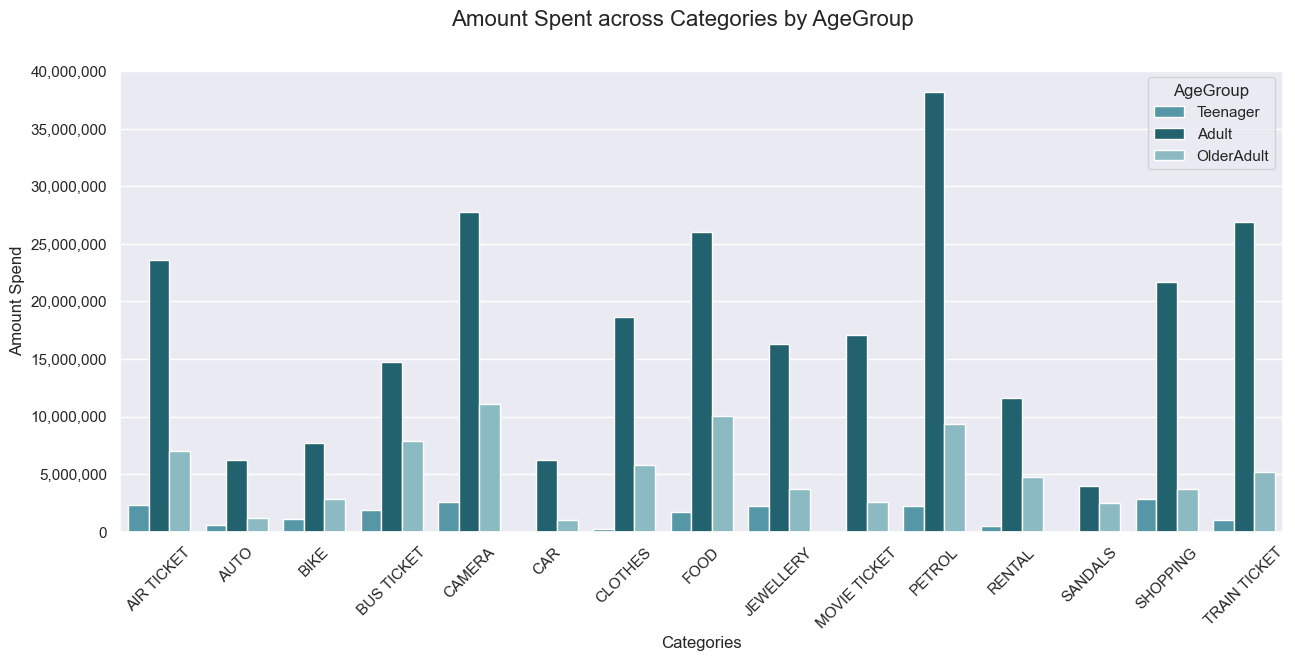

In [19]:
GrpBy_AgeGrp_Type_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

GrpBy_AgeGrp_Type_palette=['#489fb5','#16697a','#82c0cc']

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_AgeGrp_Type = Customer_Spend_Merged.groupby(['AgeGroup','Type']).agg(GrpBy_AgeGrp_Type_agg_funcs).reset_index()
GrpBy_AgeGrp_Type.columns = GrpBy_AgeGrp_Type.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_AgeGrp_Type, x='Type', y='Spend_Amt',hue="AgeGroup",hue_order=['Teenager', 'Adult', 'OlderAdult'], palette=GrpBy_AgeGrp_Type_palette, ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by AgeGroup', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


In [20]:
# condition = (Customer_Spend_Merged['Type'] == 'BIKE')
# filtered_df = Customer_Spend_Merged.loc[condition]
# # filtered_df

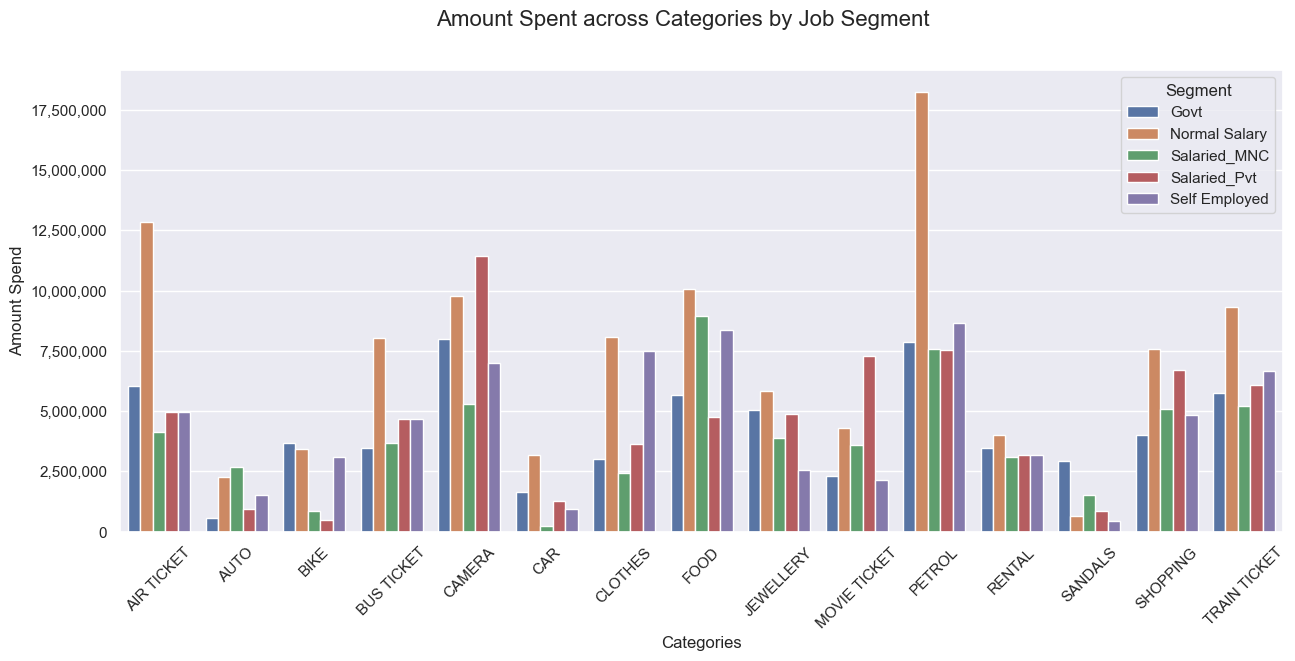

In [21]:
GrpBy_SegType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_SegType = Customer_Spend_Merged.groupby(['Segment','Type']).agg(GrpBy_SegType_agg_funcs).reset_index()
GrpBy_SegType.columns = GrpBy_SegType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_SegType, x='Type', y='Spend_Amt',hue="Segment", ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by Job Segment', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


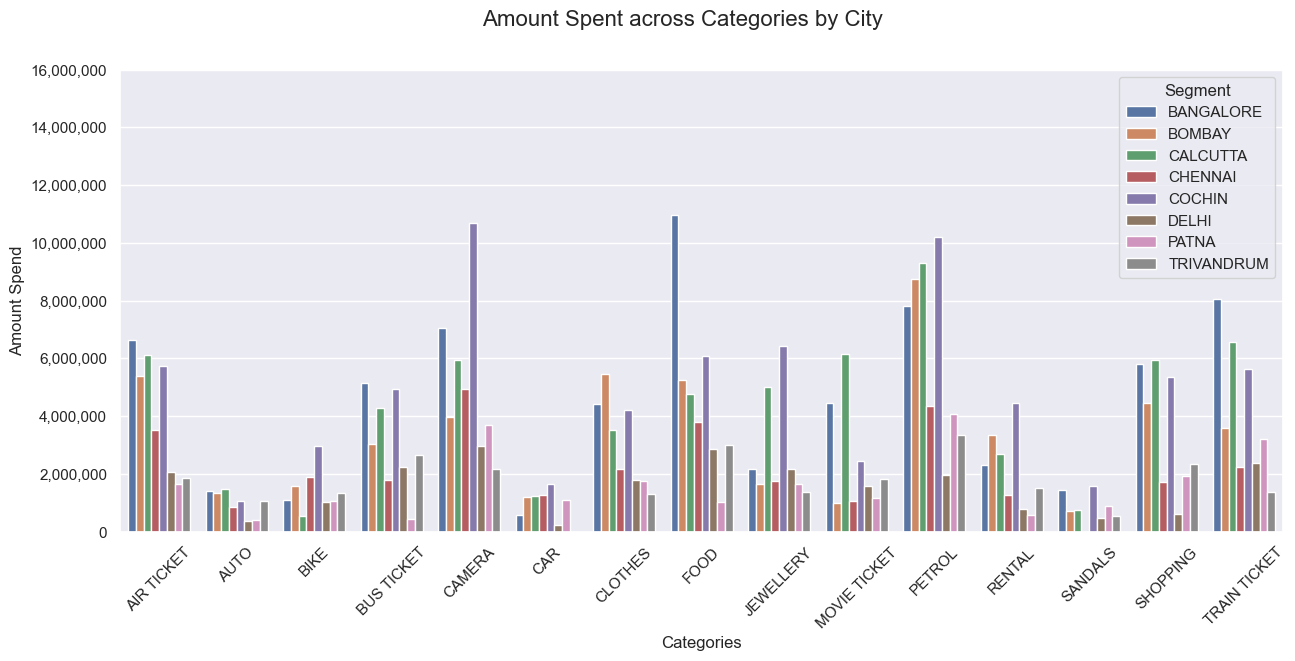

In [22]:
GrpBy_CityType_agg_funcs = {
    'Spend_Amt': ['sum'],
#     'AgeGroup':['max'],
#     'City':['max'],
#     'Segment':['max']
}

## Sort Customer by Tier Arcoss Age Group based on Total Spent Amount
GrpBy_CityType = Customer_Spend_Merged.groupby(['City','Type']).agg(GrpBy_CityType_agg_funcs).reset_index()
GrpBy_CityType.columns = GrpBy_SegType.columns.get_level_values(0)

plt.figure(figsize=(15,6))
sns.barplot(data=GrpBy_CityType, x='Type', y='Spend_Amt',hue="Segment", ci=None)  # Removed palette and ax=ax1


plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim(0, 16000000)

plt.suptitle('Amount Spent across Categories by City', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")

plt.show()


<h2>Creating Credit Score</h2>

In [68]:
All_Merged.columns
# suspected_rows = All_Merged[All_Merged['Repay_Date'] < All_Merged['Purchase_Date']]
# All_Merged.loc[suspected_rows.index, ['Repay_Date', 'Purchase_Date']] = All_Merged.loc[suspected_rows.index, ['Purchase_Date', 'Repay_Date']]

# All_Merged['Purchase_Date']=pd.to_datetime(All_Merged['Purchase_Date'], errors='coerce')
# All_Merged['Repay_Date']=pd.to_datetime(All_Merged['Repay_Date'], errors='coerce')

# suspected_rows2 = All_Merged[All_Merged['Repay_Date'] < All_Merged['Purchase_Date']]
# suspected_rows2


Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Credit_Limit', 'Company',
       'Segment', 'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt',
       'Repay_Date', 'Repay_Amt', 'Purchase_Month_Year', 'Repay_Month_Year'],
      dtype='object')

In [67]:
# Define aggregation functions
agg_funcs = {
    'Spend_Amt': ['sum'],
    'Repay_Amt': ['sum'],
    'Purchase_Date': ['min'],  # Latest purchase date
    'Repay_Date': ['max'],  # Latest repayment date
    'Credit_Limit': 'max',
    'AgeGroup':['max'],
    'Age':['max'],
    'Segment':['max'],
    'Credit_Limit':['max'],
    'City':['max'],
    'Type':'max'
}

Monthly_grp= All_Merged.groupby(['Customer', 'Tier','Purchase_Month_Year']).agg(agg_funcs).reset_index()
Monthly_grp.columns = [custom_colname(col) for col in Monthly_grp.columns]

Monthly_grp['Repaid'] = Monthly_grp['sum_Repay_Amt'] > Monthly_grp['sum_Spend_Amt']
Monthly_grp['OverLimit'] = Monthly_grp['sum_Spend_Amt'] > Monthly_grp['max_Credit_Limit']

Monthly_grp['Day_diff'] = abs(Monthly_grp['max_Repay_Date'] - Monthly_grp['min_Purchase_Date'])
Monthly_grp['Risk_Group'] = Monthly_grp.apply(credit_model, axis=1)

# Monthly_grp.loc[Monthly_grp['Customer']=='A10']
# Monthly_grp.head()

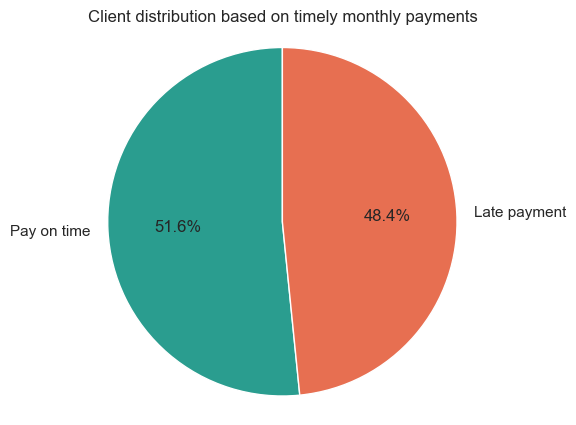

In [25]:
# ['#264653','#2a9d8f','#e9c46a','#f4a261','#e76f51']

Count_Monthly_grp_Repaid = Monthly_grp['Repaid'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_Monthly_grp_Repaid, labels=['Pay on time', 'Late payment'],colors=['#2a9d8f','#e76f51'], autopct='%1.1f%%', startangle=90)
plt.title('Client distribution based on timely monthly payments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

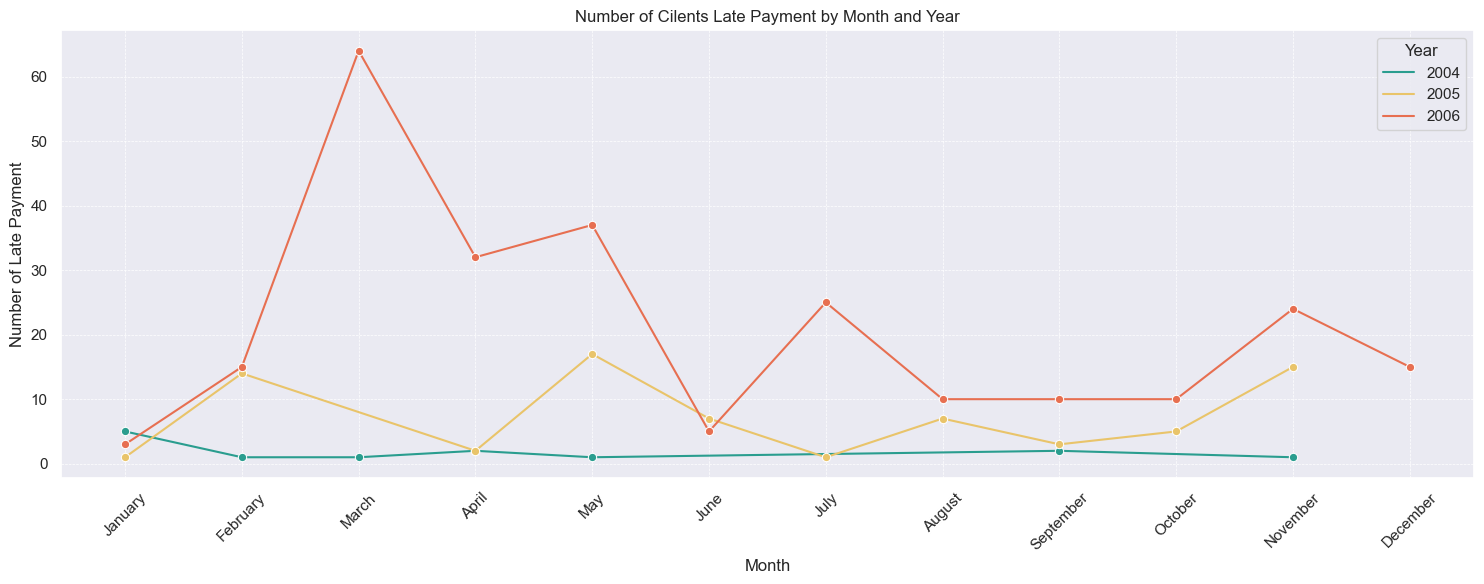

In [26]:
# ['#264653','#2a9d8f','#e9c46a','#f4a261','#e76f51']


month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

Monthly_grp['Month'] = Monthly_grp['max_Repay_Date'].dt.month_name()
Monthly_grp['Year'] = Monthly_grp['max_Repay_Date'].dt.year

# Filter Monthly_grp Who Repaid is FALSE
Monthly_grp_F_Repaid = Monthly_grp[Monthly_grp['Repaid'] == False]

Count_Monthly_grp_F_Repaid = Monthly_grp_F_Repaid.groupby(['Month','Year']).size().reset_index(name='CountFalse')
Count_Monthly_grp_F_Repaid.columns = Count_Monthly_grp_F_Repaid.columns.get_level_values(0)
#[''.join(col).strip() for col in Count_Monthly_grp_F_Repaid.columns]

Count_Monthly_grp_F_Repaid['Month'] = pd.Categorical(Count_Monthly_grp_F_Repaid['Month'], categories=month_order, ordered=True)
Count_Monthly_grp_F_Repaid = Count_Monthly_grp_F_Repaid.sort_values(by=['Year', 'Month'])

# Plot using seaborn
plt.figure(figsize=(15,6))
sns.lineplot(x='Month', y='CountFalse',hue='Year', data=Count_Monthly_grp_F_Repaid, marker="o",palette=['#2a9d8f','#e9c46a','#e76f51'])

plt.title('Number of Cilents Late Payment by Month and Year')
plt.ylabel('Number of Late Payment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Year',loc='upper right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [65]:
# Monthly_grp_F_Repaid['Repaid']
# Count_Monthly_grp_F_Repaid

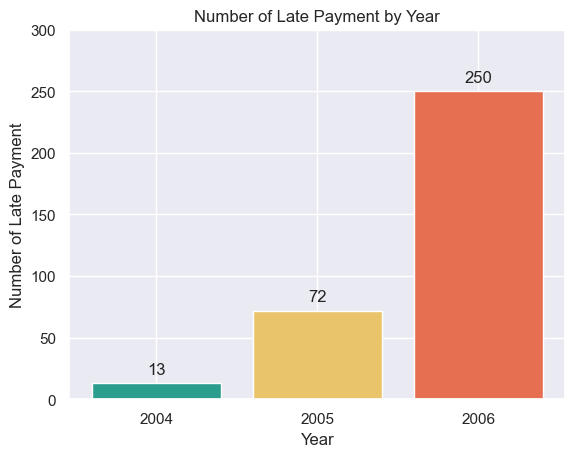

In [66]:
Count_Monthly_grp_F_Repaid = Monthly_grp_F_Repaid.groupby(['Year']).size().reset_index(name='No')

fig, ax = plt.subplots()

bar_labels =['2004','2005','2006']
bar_colors = ['#2a9d8f','#e9c46a','#e76f51']

bars = ax.bar(Count_Monthly_grp_F_Repaid['Year'], Count_Monthly_grp_F_Repaid['No'], color=bar_colors)

# Displaying the count on each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom')
    
ax.set_ylabel('Number of Late Payment')
ax.set_xlabel('Year')
ax.set_title('Number of Late Payment by Year')

ax.set_xticks(Count_Monthly_grp_F_Repaid['Year'])
ax.set_ylim([0, 300])

plt.show()

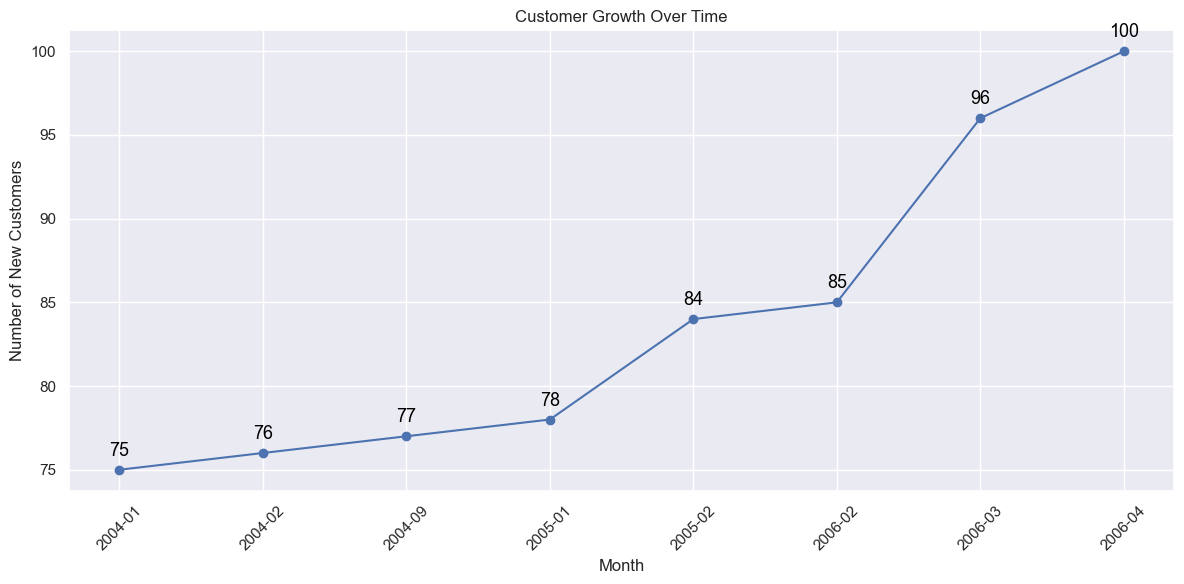

In [30]:
# Define aggregation functions
agg_funcs = {
    'Purchase_Date': ['min'],  # Latest purchase date
    'AgeGroup':['max'],
    'Age':['max'],
    'City':['max'],
    'Purchase_Month_Year':['min']
}

first_purchase = All_Merged.groupby(['Customer']).agg(agg_funcs).reset_index()
first_purchase.columns = [custom_colname(col) for col in first_purchase.columns]
# first_purchase
# Step 2: Group by the month/year and count the number of customers
first_purchase['Purchase_Month'] = first_purchase['min_Purchase_Date'].dt.to_period('M') # Extracting month and year

monthly_growth = first_purchase.groupby('Purchase_Month').size().reset_index(name='New_Customers')
monthly_growth['Cumulative_Customers'] = monthly_growth['New_Customers'].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_growth['Purchase_Month'].astype(str), monthly_growth['Cumulative_Customers'], marker='o')
plt.title('Customer Growth Over Time')
plt.xlabel('Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate each data point
for idx, row in monthly_growth.iterrows():
    plt.annotate(f"{row['Cumulative_Customers']}", 
                 (row['Purchase_Month'].strftime('%Y-%m'), row['Cumulative_Customers']), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=13, 
                 color='black')


plt.show()

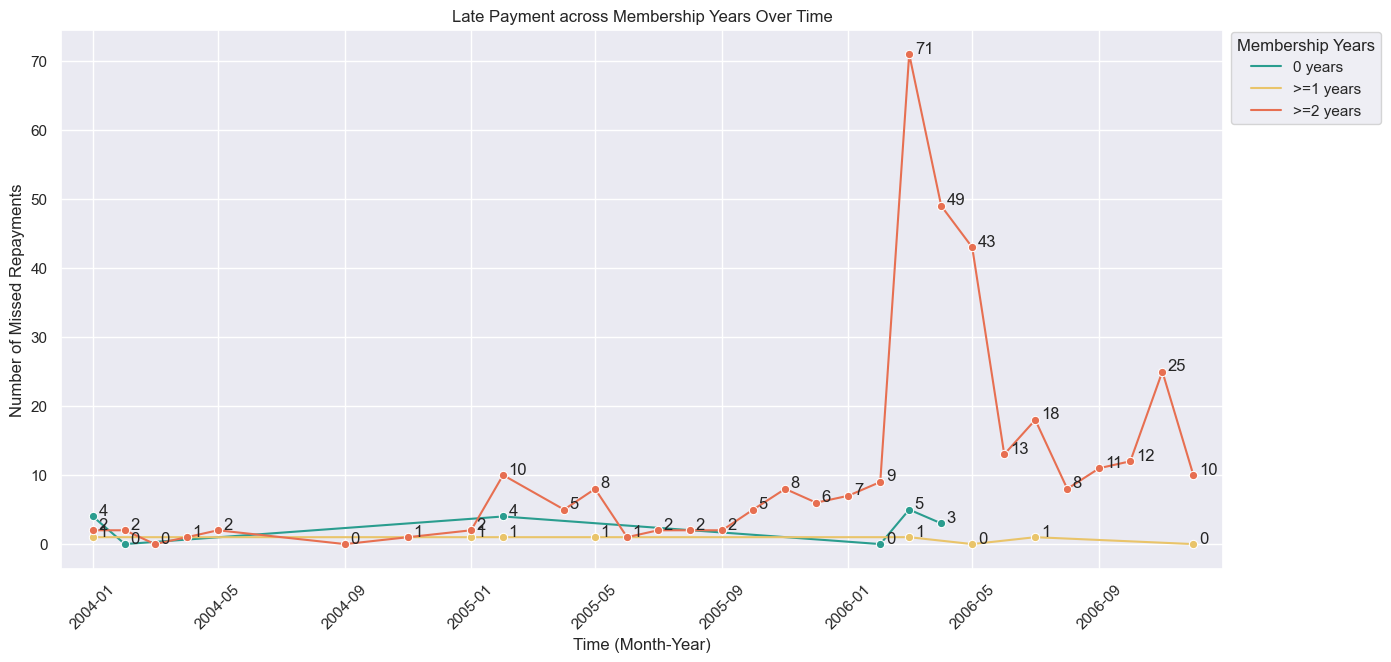

In [31]:
#i wan to show customer that be with us 2 year record.

GrpBy_Repaid_TierAge_Type_agg_funcs = {
        'Tier': ['max'],
        'max_Repay_Date':['max'],
        'min_Purchase_Date':['min','count'],
}



## Customer Info
GrpBy_Repaid_TierAge_Type = Monthly_grp.groupby(['Customer']).agg(GrpBy_Repaid_TierAge_Type_agg_funcs).reset_index()
GrpBy_Repaid_TierAge_Type.columns = [custom_colname(col) for col in GrpBy_Repaid_TierAge_Type.columns]

GrpBy_Repaid_TierAge_Type['Membership_Years'] = GrpBy_Repaid_TierAge_Type['max_max_Repay_Date'] - GrpBy_Repaid_TierAge_Type['min_min_Purchase_Date']
GrpBy_Repaid_TierAge_Type['Membership_Years'] = (abs(GrpBy_Repaid_TierAge_Type['Membership_Years'].dt.days) // 365.25).astype(int)
GrpBy_Repaid_TierAge_Type = GrpBy_Repaid_TierAge_Type.drop(columns=['max_max_Repay_Date', 'min_min_Purchase_Date','count_min_Purchase_Date'])


# Monthly Transaction_Data
filtered_data = ['Customer','max_Repay_Date','max_AgeGroup','Repaid','OverLimit','Risk_Group']
Transaction_data = Monthly_grp[filtered_data]
Transaction_data['max_Repay_Date'] = pd.to_datetime(Transaction_data['max_Repay_Date'])
Transaction_data['max_Repay_Date'] = Transaction_data['max_Repay_Date'].dt.to_period('M')

# Combine Customer info with Monthly Transanction_data
result = pd.merge(Transaction_data, GrpBy_Repaid_TierAge_Type, on='Customer', how='inner')

aggregated_data_agg_funcs = {
    'Repaid':['sum'],
#     'OverLimit':['sum'],
#     'max_Tier':['max'],
#     'max_AgeGroup':['max'],
}
#we can change Membership_Years to max_Tier or max_AgeGroup to check which group is lated payment
aggregated_data = result.groupby(['max_Repay_Date', 'Membership_Years']).agg(aggregated_data_agg_funcs).reset_index()
aggregated_data.columns = aggregated_data.columns.get_level_values(0)
aggregated_data = aggregated_data.sort_values(by='max_Repay_Date')
aggregated_data['max_Repay_Date'] = aggregated_data['max_Repay_Date'].dt.to_timestamp()


pat_colors = ['#2a9d8f','#e9c46a','#e76f51']

# Now plot using seaborn
plt.figure(figsize=(15,7))
sns.lineplot(data=aggregated_data, x='max_Repay_Date', y='Repaid', hue='Membership_Years',palette=pat_colors, marker='o', ci=None)
plt.title('Late Payment across Membership Years Over Time')
plt.ylabel('Number of Missed Repayments')
plt.xlabel('Time (Month-Year)')
plt.xticks(rotation=45)
  
start_date = pd.Timestamp('2003-12-01')
end_date = pd.Timestamp('2006-12-30')
plt.xlim(start_date, end_date)

handles, _ = plt.gca().get_legend_handles_labels()
# Notice that 'Membership Years' is added to the list of labels. It's for the legend title.
labels = ['0 years', '>=1 years', '>=2 years']  

# Add legend with custom labels
leg = plt.legend(handles=handles, title='Membership Years', labels=labels, loc='upper left', frameon=True, bbox_to_anchor=(1, 1.01))
leg.get_title().set_ha('left')

# Annotate each data point
for idx, row in aggregated_data.iterrows():
    plt.annotate(f"{row['Repaid']:.0f}", 
                 (row['max_Repay_Date'], row['Repaid']), 
                 textcoords="offset points", 
                 xytext=(4,1), 
                 ha='left')


plt.show()
# combined_data


In [32]:
# aggregated_data
# Transaction_data

In [33]:
# GrpBy_Repaid_TierAge_Type.loc[GrpBy_Repaid_TierAge_Type['Membership_Years']==0]
# aggregated_data.tail(20)

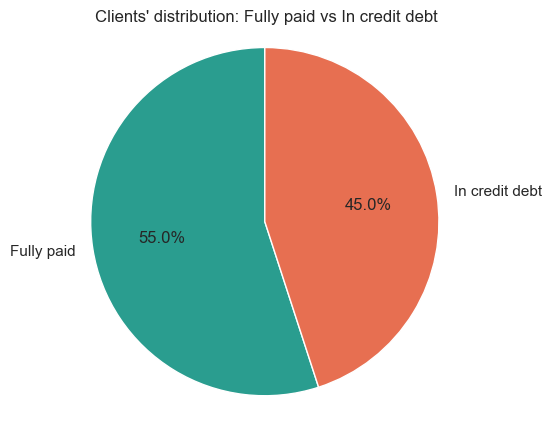

In [34]:
# Define aggregation functions
overall_agg_funcs = {
    'sum_Repay_Amt': ['sum'],
    'sum_Spend_Amt': ['sum'],
    'min_Purchase_Date': ['min'],  # Latest purchase date
}

Count_Customer_FullyPaid= Monthly_grp.groupby(['Customer']).agg(overall_agg_funcs).reset_index()
Count_Customer_FullyPaid.columns = Count_Customer_FullyPaid.columns.get_level_values(0)


Count_Customer_FullyPaid['InDebt'] = Count_Customer_FullyPaid['sum_Repay_Amt'] > Count_Customer_FullyPaid['sum_Spend_Amt']


Count_InDebt = Count_Customer_FullyPaid['InDebt'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Count_InDebt, labels=['Fully paid', 'In credit debt'],colors=['#2a9d8f','#e76f51'], autopct='%1.1f%%', startangle=90)
plt.title('Clients\' distribution: Fully paid vs In credit debt')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

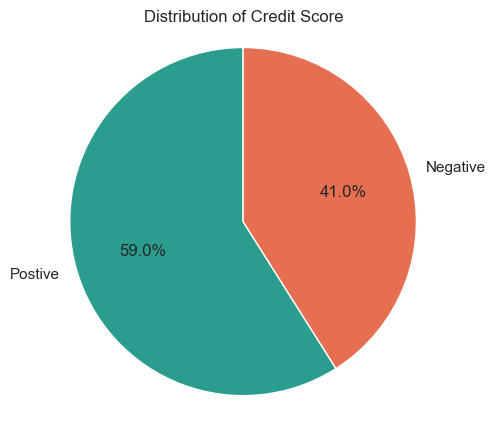

In [35]:
CreditScore_agg_funcs = {
    'Risk_Group': ['sum']
}

Count_CreditScore = Monthly_grp.groupby(['Customer']).agg(CreditScore_agg_funcs).reset_index()
Count_CreditScore.columns = Count_CreditScore.columns.get_level_values(0)

Count_CreditScore['Credit_Score'] = Count_CreditScore['Risk_Group'] >=1 #(Postive or Negative)

Pie_Count_CreditScore = Count_CreditScore['Credit_Score'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(Pie_Count_CreditScore, labels=['Postive', 'Negative'],colors=['#2a9d8f','#e76f51'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Credit Score')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

In [36]:
# GrpBy_Repaid_TierAge_Type

result2 = pd.merge(Monthly_grp, GrpBy_Repaid_TierAge_Type, on='Customer', how='inner')
# result2
# Scatter_CreditScore

In [37]:
# import some preprocessing module
from sklearn import preprocessing

ScatterCredit_agg_funcs = {
    'sum_Spend_Amt': ['sum'],
    'sum_Repay_Amt':['sum'],
    'max_Age':['max'],
    'Risk_Group':['sum'],
    'Tier':['max'],
    'max_Segment':['max'],
    'max_City':['max'],
    'Membership_Years':['max']
}

Scatter_CreditScore = result2.groupby(['Customer']).agg(ScatterCredit_agg_funcs).reset_index()
Scatter_CreditScore.columns = Scatter_CreditScore.columns.get_level_values(0)

Scatter_CreditScore['Repay_to_Spend_Raito']=np.sqrt(Scatter_CreditScore['sum_Repay_Amt']/Scatter_CreditScore['sum_Spend_Amt'])

preferred_order_tier = ['Silver', 'Gold', 'Platinum']

# Scatter_CreditScore

In [38]:
# Scatter_CreditScore.dtypes
# Scatter_CreditScore.iloc[23]

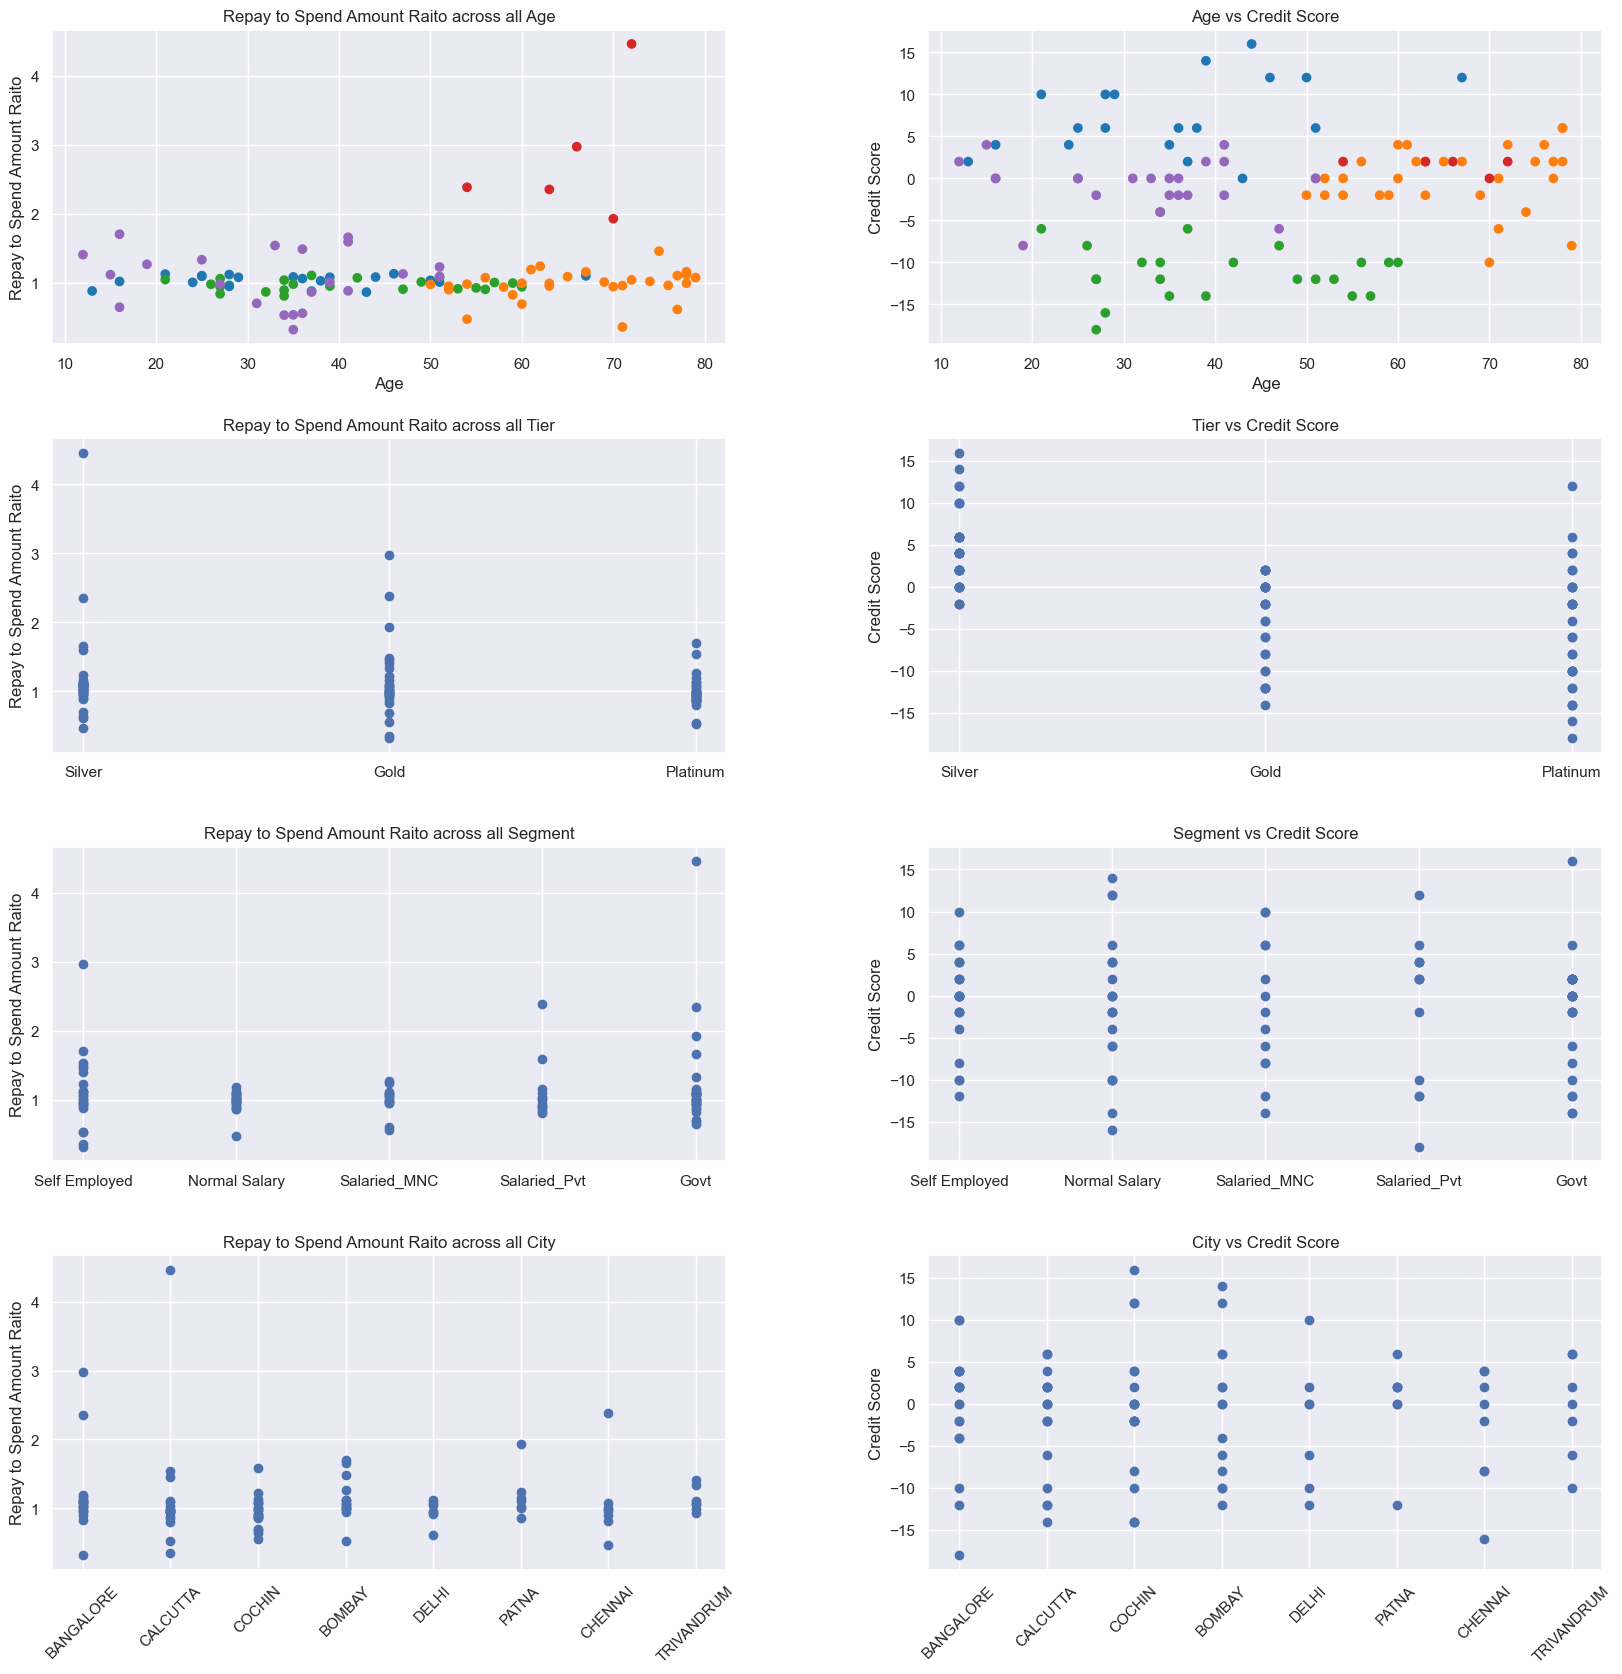

In [39]:
# Step 2: Data Standardization
# scaler = StandardScaler()
features_to_scale = ['max_Age','sum_Spend_Amt','Risk_Group','Repay_to_Spend_Raito']
#df_scaled = scaler.fit_transform(Scatter_CreditScore[features_to_scale])
df_scaled = preprocessing.scale(Scatter_CreditScore[features_to_scale])


# Step 3: Applying KMeans Clustering
kmeans = KMeans(n_clusters=5) 
Scatter_CreditScore['Cluster'] = kmeans.fit_predict(df_scaled)

distinct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
Scatter_CreditScore['Color'] = Scatter_CreditScore['Cluster'].apply(lambda x: distinct_colors[x])

# Create a grid of subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

Scatter_CreditScore['Color'] = Scatter_CreditScore['Cluster'].apply(lambda x: distinct_colors[x])


# Visualization using the right DataFrame and columns
sc1 = axes[0,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_Age'],c=Scatter_CreditScore['Color'])
axes[0,0].set_title('Repay to Spend Amount Raito across all Age')
axes[0,0].set_ylabel('Repay to Spend Amount Raito')

sc2 = axes[0,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_Age'], c=Scatter_CreditScore['Color'])
axes[0,1].set_title('Age vs Credit Score')
axes[0,1].set_ylabel('Credit Score')

sc3 = axes[1,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['Tier'])
axes[1,0].set_title('Repay to Spend Amount Raito across all Tier')
axes[1,0].set_ylabel('Repay to Spend Amount Raito')

sc4 = axes[1,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['Tier'])
axes[1,1].set_title('Tier vs Credit Score')
axes[1,1].set_ylabel('Credit Score')

sc5 = axes[2,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_Segment'])
axes[2,0].set_title('Repay to Spend Amount Raito across all Segment')
axes[2,0].set_ylabel('Repay to Spend Amount Raito')

sc6 = axes[2,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_Segment'])
axes[2,1].set_title('Segment vs Credit Score')
axes[2,1].set_ylabel('Credit Score')

sc5 = axes[3,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['max_City'])
axes[3,0].set_title('Repay to Spend Amount Raito across all City')
axes[3,0].set_ylabel('Repay to Spend Amount Raito')

sc6 = axes[3,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['max_City'])
axes[3,1].set_title('City vs Credit Score')
axes[3,1].set_ylabel('Credit Score')

# sc7 = axes[4,0].scatter(y=Scatter_CreditScore['Repay_to_Spend_Raito'], x=Scatter_CreditScore['Membership_Years'])
# axes[4,0].set_title('Repay to Spend Amount Raito across all Membership_Years')
# axes[4,0].set_ylabel('Repay to Spend Amount Raito')

# sc8 = axes[4,1].scatter(y=Scatter_CreditScore['Risk_Group'], x=Scatter_CreditScore['Membership_Years'])
# axes[4,1].set_title('Membership_Years vs Credit Score')
# axes[4,1].set_ylabel('Credit Score')


# Set x-label for all subplots
for ax in [axes[0,0], axes[0,1]]:
    ax.set_xlabel('Age')
    
# Set x-axis ticks and labels for both plots
for ax in [axes[1,0], axes[1,1]]:
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Silver', 'Gold', 'Platinum'])
    
for ax in [axes[3,0], axes[3,1]]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
# Scatter_CreditScore


## Bankrupt

Currently, there is not cilent who declared Bankrupt. 

We can use Repay Amount to Spend Amount Raito to see how many cilents are spent double that what they can repay. Based on that and also how many time did they spent over limit and late payment to determine chance of them become bankrupt.

Definition of Brankrupt:
- Unable to repay outstanding debts
- Repay amount to spend amount is negative range
- Late payment and bad credit score

We break them into 4 group:
- Bad Credit Score, negative repay amount to spend amount Ratio = possible to bankupt
- Good Credit Score, negative repay amount to spend amount Ratio = payable the debt
- Bad Credit Score, postive repay amount to spend amount Ratio = late payment most
- Good Credit Score, postive repay amount to spend amount Ratio = good.


In [40]:
%%capture
Monthly_grp_checkCilent = Monthly_grp.copy()

customer_data = Monthly_grp_checkCilent.loc[Monthly_grp['Customer'] == 'A1']

customer_data['Date'] = customer_data['Purchase_Month_Year'].dt.to_timestamp()

plt.figure(figsize=(10, 6))
plt.plot(customer_data['Date'], customer_data['sum_Spend_Amt'], marker='o')
plt.title('Spending Over Time for Customer A21')
plt.xlabel('Date')
plt.ylabel('Spend Amount')

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylim((0,3500000))
plt.tight_layout()
plt.show()
# customer_data

In [63]:
Clean_Monthly = Monthly_grp.copy()
Clean_Monthly.rename(columns={
    'sum_Spend_Amt': 'Spend_Amt',
    'sum_Repay_Amt': 'Repay_Amt',
    'min_Purchase_Date': 'Purchase_Date',
    'max_Repay_Date': 'Repay_Date',
    'max_Credit_Limit': 'Credit_Limit',
    'max_AgeGroup': 'AgeGroup',
    'max_Age': 'Age',
    'max_Segment': 'Segment',
    'max_City': 'City',
    'max_Type':'Type'
}, inplace=True)

Clean_Monthly = Clean_Monthly.drop(columns=['Purchase_Month_Year'])
Clean_Monthly['Repay_To_Spend_Ratio'] = Clean_Monthly['Repay_Amt']/Clean_Monthly['Spend_Amt']

# Clean_Monthly.head()
# All_Merged

In [42]:
# def checkBankrupt (creditscore,bankrupt):
#     if creditscore < 0 and bankrupt <:
#         return 'Possible to bankrupt'
    
def skewed (mean,median):
    if mean > median:
        #return 'Left'
        return -1
    elif mean < median:
        #return 'Right'
        return 1
    else:
        #return 'Normal'
        return 0
    
# def groupname(Skewed,CreditScore,Repay_To_Spend_ratio):

def groupname(Skewed,CreditScore,Bankrupt,NumTransaction):
    score = 0
# determine monthly raito - ability to pay
    if Skewed < 0:
        score -=1
    elif Skewed >0:
        score +=1
    else:
        score = score
        
# sense of management their wealth, plan ahead
    if CreditScore < 0:
        score -=1
    elif CreditScore > 0:
        score +=1
    else:
        score = score

# 50% / 75% of debt is repaid. 0.5 or 0.25, how much they own
    if Bankrupt == 1:
        score -=1
    elif Bankrupt == 0:
        score +=1
        
# transaction too litte
    if NumTransaction < 5:
        score -=2
    else:
        score = score
        
        
    if score >= 0:
        score = 1
    elif score <=-3:
        score = -3
    elif score < 0:
        score = score
    
    return score


In [62]:
# Clean_Monthly.head(2)
# Clean_Monthly['Repay_Date'].max()

In [44]:
#take 1 user that have to user for 3 years out to see spending habit from its avg 
#spending habit to see if he/she will brankupt

Max_Date = Clean_Monthly['Repay_Date'].max()

# Define aggregation functions
overall_agg_funcs = {
    'Tier':['max'],
#   'Credit_Limit':['max'],
    'Spend_Amt': ['max','count'],
    'Repay_Amt': ['max'],
    'Purchase_Date': ['min'],# Latest purchase date
    'Repay_Date':['max'],
    'Risk_Group':['sum'],
    'Age':['max'],
    'Repaid':['sum'],
    'OverLimit':['sum'],
    'Day_diff':['max'],
    'Repay_To_Spend_Ratio':['mean','median'],
    'Type':['max']
}

Bankrupt_Predication= Clean_Monthly.groupby(['Customer']).agg(overall_agg_funcs).reset_index()
Bankrupt_Predication.columns = [custom_colname(col) for col in Bankrupt_Predication.columns]

# Bankrupt_Predication['real'] = Bankrupt_Predication['sum_Spend_Amt'] == Bankrupt_Predication['max_Repay_Date']
Bankrupt_Predication['Years_Diff'] = (Bankrupt_Predication['max_Repay_Date']-Bankrupt_Predication['min_Purchase_Date']).dt.days
Bankrupt_Predication['Tier_Years'] = Bankrupt_Predication['Years_Diff'] // 365
Bankrupt_Predication['Tier_Months'] = (Bankrupt_Predication['Years_Diff'] % 365) // 30
Bankrupt_Predication['Years_and_Month'] = Bankrupt_Predication['Tier_Years'].astype(str) + " years, " + Bankrupt_Predication['Tier_Months'].astype(str) + " months"
Bankrupt_Predication['Total_Months'] = (Bankrupt_Predication['Tier_Years']*12)+Bankrupt_Predication['Tier_Months']
Bankrupt_Predication['Last_Repay_Date_Diff'] = Max_Date - Bankrupt_Predication['max_Repay_Date']


Bankrupt_Predication['RepayToSpend_Ratio']=Bankrupt_Predication['max_Repay_Amt']/Bankrupt_Predication['max_Spend_Amt']
Bankrupt_Predication['Outstanding_Amount'] = Bankrupt_Predication['max_Repay_Amt']-Bankrupt_Predication['max_Spend_Amt']
Bankrupt_Predication['Bankrupt']= Bankrupt_Predication['RepayToSpend_Ratio']<0.5


# We need user that have slight more transaction history in order to understand average spend
Bankrupt_Predication.loc[Bankrupt_Predication['Tier_Years']>=1]

#check if monthly mean_Repay_to_Spent decreasing or increasing
Bankrupt_Predication['skewed'] = Bankrupt_Predication.apply(lambda row: skewed(row['mean_Repay_To_Spend_Ratio'], row['median_Repay_To_Spend_Ratio']), axis=1)


#filtered those who postive cash flow with bad credit score. row['skewed'],row['sum_Risk_Group'],
Bankrupt_Predication['Bankrupt_Score'] = Bankrupt_Predication.apply(lambda row: groupname(row['skewed'],row['sum_Risk_Group'],row['Bankrupt'],row['count_Spend_Amt']),axis=1)
filtered_list=['Customer','max_Tier','Total_Months','Bankrupt_Score','Outstanding_Amount','RepayToSpend_Ratio','skewed','sum_Risk_Group','Bankrupt','count_Spend_Amt','sum_Repaid','sum_OverLimit','Last_Repay_Date_Diff','max_Type']
# filtered_list=['Customer','max_Tier','Total_Months','Bankrupt_Score','RepayToSpend_Ratio','skewed','sum_Risk_Group','count_Spend_Amt','sum_Repaid','sum_OverLimit','Last_Repay_Date_Diff']

# 50% / 75% of debt is repaid. ( we look at those that are 0 to -2 range.)
Filtered_Bankrupt_Predication = Bankrupt_Predication[filtered_list]
# Filtered_Bankrupt_Predication.loc[(Bankrupt_Predication['Bankrupt_Score']>0) & (Bankrupt_Predication['count_Spend_Amt']>5)]
# Filtered_Bankrupt_Predication.loc[(Bankrupt_Predication['Bankrupt_Score']==-2)]


In [45]:
# Check if function for bankrupt score
# Bankrupt_Predication[filtered_list].loc[Bankrupt_Predication['RepayToSpend_Ratio']<0.5]
# Filtered_Bankrupt_Predication['Bankrupt_Score'].unique()
# Filtered_Bankrupt_Predication.dtypes
# MoreTransaction_Score

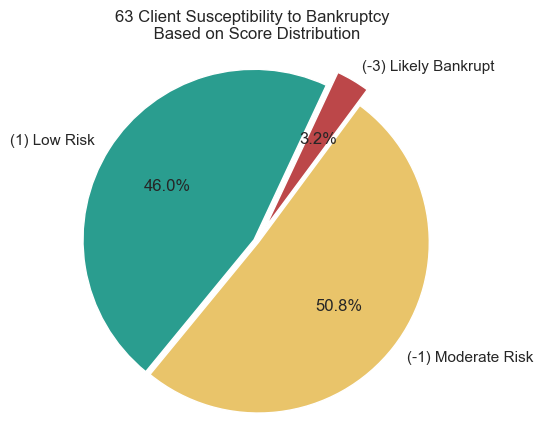

In [46]:
MoreTransaction_Score = Filtered_Bankrupt_Predication.loc[(Bankrupt_Predication['count_Spend_Amt']>2)]
Pie_Count_MoreTransaction_Score =  MoreTransaction_Score['Bankrupt_Score'].value_counts().sort_index(ascending=False)


explode = (0.02, 0.01, 0.1)
bar_colors = ['#2a9d8f','#e9c46a','#bc4749']

Labels=['(1) Low Risk','(-1) Moderate Risk', '(-3) Likely Bankrupt']

# Create the pie chart Pie_Count_MoreTransaction_Score.index
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(Pie_Count_MoreTransaction_Score, colors=bar_colors, labels=Labels, autopct='%1.1f%%', startangle=65,explode=explode)
plt.title('63 Client Susceptibility to Bankruptcy \n Based on Score Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Labels=[' 1 - Low Risk','-1 - Moderate Risk', '-2 - High Risk', '-3 - Likely Brankrupt']
Labels=[' 1 - Low Risk','-1 - Moderate Risk', '-3 - Likely Bankrupt']
# plt.legend(wedges, Labels, loc="upper left", title="Bankrupt Score", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


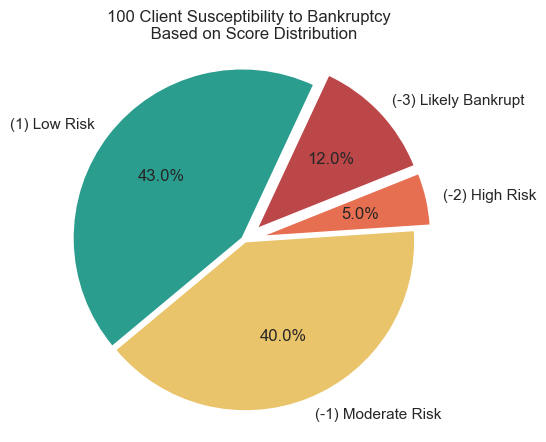

In [47]:

Pie_Count_Bankrupt_Score = Filtered_Bankrupt_Predication['Bankrupt_Score'].value_counts().sort_index(ascending=False)


explode = (0.02, 0.01, 0.1, 0.1)
bar_colors2 = ['#2a9d8f','#e9c46a','#e76f51','#bc4749']

Labels=['(1) Low Risk','(-1) Moderate Risk', '(-2) High Risk', '(-3) Likely Bankrupt']

# Create the pie chart Pie_Count_Bankrupt_Score.index
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(Pie_Count_Bankrupt_Score, labels=Labels, colors=bar_colors2, autopct='%1.1f%%', startangle=65,explode=explode)
plt.title('100 Client Susceptibility to Bankruptcy \n Based on Score Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.legend(wedges, Labels, loc="upper left", title="Bankrupt Score", bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

#have to include transaction then lower 5.

## Fraud detection

In [48]:
# Clean_Monthly.head() #monthly transaction

In [49]:
# Customer Information
overall_agg_funcs = {
    'Tier':['max'],
#   'Credit_Limit':['max'],
    'Spend_Amt': ['count','mean'],
#   'Repay_Amt': ['max','mean'],
    'Risk_Group':['sum'],
    'Age':['max'],
#   'Repaid':['sum'],
#   'OverLimit':['sum'],
    'Day_diff':['max'],
    'Segment':['max'],
    'City':['max']
}

Fraud_Detection= Clean_Monthly.groupby(['Customer']).agg(overall_agg_funcs).reset_index()
Fraud_Detection.columns = [custom_colname(col) for col in Fraud_Detection.columns]

Fraud_Detection['Membership_Years']=(Fraud_Detection['max_Day_diff'].dt.days//365)
Fraud_Detection = Fraud_Detection.drop(columns=['max_Day_diff'])
# Fraud_Detection

In [50]:
def check_Anomalies (Origin,Location,Spending,Repay,Usunal_Spending):    
    
    Anomalies = 0
    
    if Origin != Location:
        Anomalies +=1
        
    if Spending > Repay:
        Anomalies +=1
        
    if Usunal_Spending == True:
        Anomalies +=1
    else:
        Anomalies = Anomalies
    
    return Anomalies
        

In [51]:
# those with 1 transaction or sudden strike in transaction?
# how often they have transaction?
# if user spent more then their AVG Spending?
# transaction that nv payback or no pack back at all
# do we have user where transaction is different city?
#i wan to check if their monthly spending go pass their avg monethly spending?


# Set float display format
pd.options.display.float_format = '{:.2f}'.format


Fraud_MonthlyTrans_Filtered = ['Customer','Spend_Amt','Repay_Amt','Purchase_Date','OverLimit','Repaid','City','Type','AgeGroup']
Filtered_CM_Transaction = Clean_Monthly[Fraud_MonthlyTrans_Filtered]

# Merge Transaction Info With Customer Info
Frau_Monthly_DF = pd.merge(Filtered_CM_Transaction,Fraud_Detection,on=['Customer'],how='inner')


#different monthly spend amt and average spend 
Frau_Monthly_DF['Difference_From_Avg'] = Frau_Monthly_DF['Spend_Amt'] - Frau_Monthly_DF['mean_Spend_Amt']

# Filter rows where the difference is significantly different, e.g., more than 20% of the average
threshold = 0.20
#we check both negative or postive different in amount. as long as it pass threshold of avg spent.
Frau_Monthly_DF['Anomalies'] = abs(Frau_Monthly_DF['Difference_From_Avg']) / Frau_Monthly_DF['mean_Spend_Amt']
Frau_Monthly_DF['Anomalies'] = Frau_Monthly_DF['Anomalies'] > threshold


Frau_Monthly_DF['Anomalies_Score'] = Frau_Monthly_DF.apply(lambda row: check_Anomalies(row['max_City'],row['City'],row['Spend_Amt'],row['Repay_Amt'],row['Anomalies']),axis=1)

# Frau_Monthly_DF.loc[(Frau_Monthly_DF['Anomalies_Score'])==0]


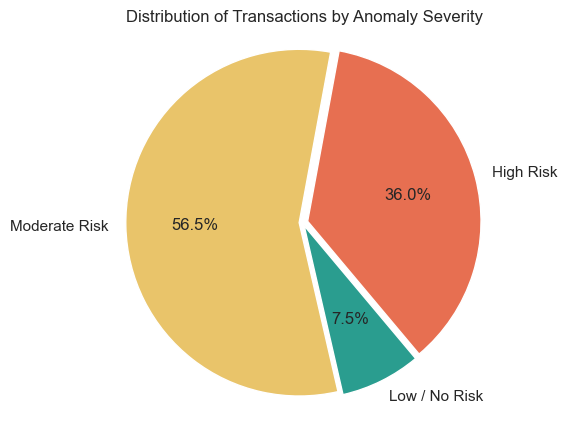

In [52]:

Pie_Count_Anomalies_Score = Frau_Monthly_DF['Anomalies_Score'].value_counts().sort_index(ascending=False)


explode = (0.03, 0.02, 0.02)
bar_colors = ['#e76f51','#e9c46a','#2a9d8f']
Anomalies_Labels=['High Risk', 'Moderate Risk', 'Low / No Risk']

# Create the pie chart
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(Pie_Count_Anomalies_Score, labels=Anomalies_Labels, colors=bar_colors, autopct='%1.1f%%', startangle=310, explode = explode)
plt.title('Distribution of Transactions by Anomaly Severity')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.legend(wedges, Anomalies_Labels, loc="upper left", title="Anomalies Score", bbox_to_anchor=(1.1, 1))

# Show the plot
plt.show()

#have to include transaction then lower 5.

In [53]:
# Frau_Monthly_DF.head(5)

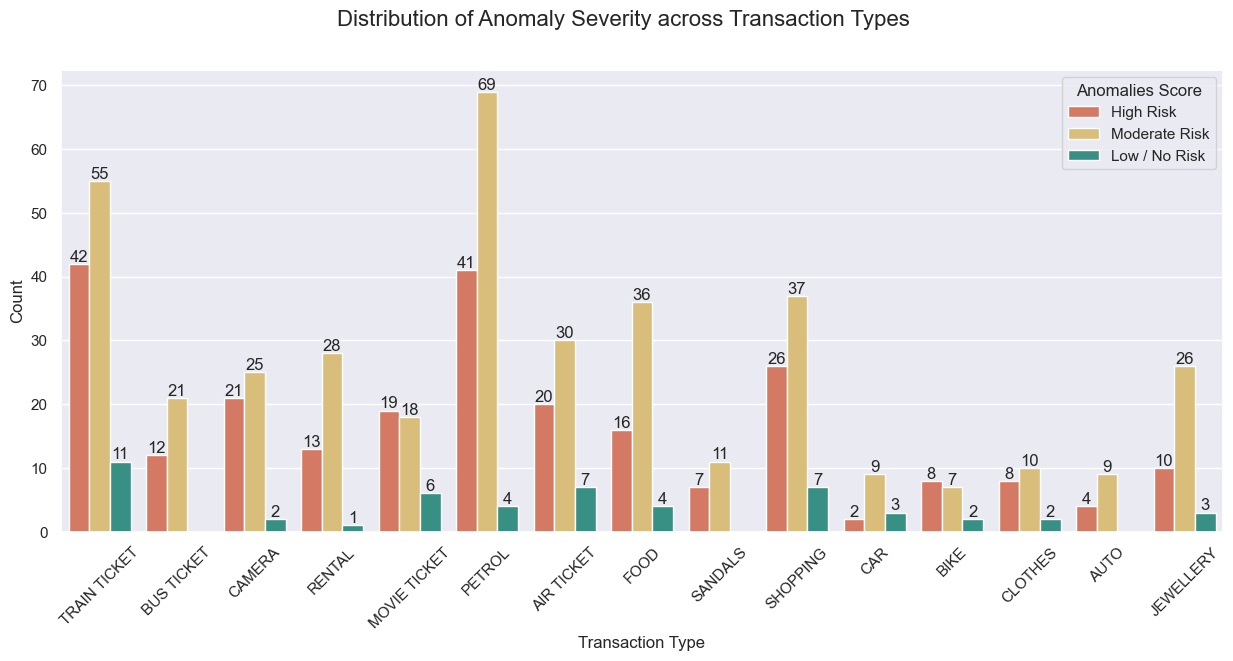

In [54]:
plt.figure(figsize=(15,6))

# Create the countplot
ax = sns.countplot(data=Frau_Monthly_DF, x='Type', hue="Anomalies_Score", hue_order=[2,1,0], palette=bar_colors)

plt.xticks(rotation=45)
plt.suptitle('Distribution of Anomaly Severity across Transaction Types', fontsize=16)
plt.ylabel("Count")
plt.xlabel("Transaction Type")
plt.legend(title='Anomalies Score', labels=Anomalies_Labels, loc='upper right')

# Annotate each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()


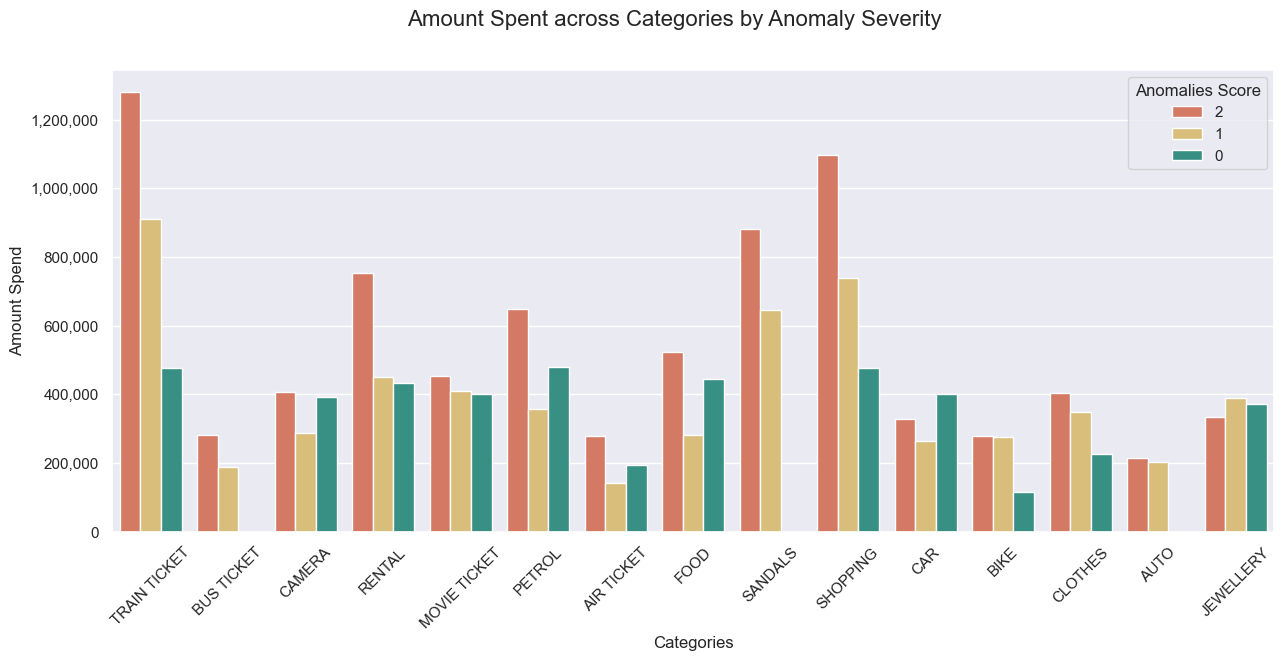

In [55]:
plt.figure(figsize=(15,6))
ax = sns.barplot(data=Frau_Monthly_DF, x='Type', y='Spend_Amt',hue="Anomalies_Score",hue_order=[2,1,0],palette=bar_colors, ci=None)  # Removed palette and ax=ax1

plt.xticks(rotation=45)

#format y axis to dollar
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.suptitle('Amount Spent across Categories by Anomaly Severity', fontsize=16)
plt.ylabel("Amount Spend")
plt.xlabel("Categories")
plt.legend(title='Anomalies Score', loc='upper right')


plt.show()

In [56]:
Frau_Monthly_DF.columns

Index(['Customer', 'Spend_Amt', 'Repay_Amt', 'Purchase_Date', 'OverLimit',
       'Repaid', 'City', 'Type', 'AgeGroup', 'max_Tier', 'count_Spend_Amt',
       'mean_Spend_Amt', 'sum_Risk_Group', 'max_Age', 'max_Segment',
       'max_City', 'Membership_Years', 'Difference_From_Avg', 'Anomalies',
       'Anomalies_Score'],
      dtype='object')

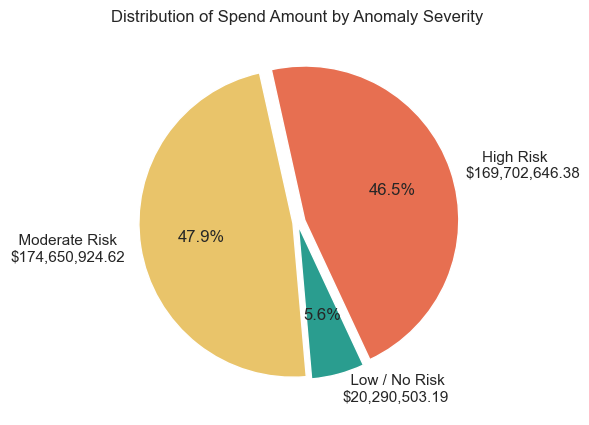

In [57]:
Pie_Count_Anomalies_Score = Frau_Monthly_DF.groupby(['Anomalies_Score'])['Spend_Amt'].sum().sort_index(ascending=False)
explode = (0.05, 0.03, 0.02)

# Define labels with both the index and the actual sum value
labels = ["{:^17}\n{}".format(i, "${:,.2f}".format(v)) for i, v in zip(Anomalies_Labels, Pie_Count_Anomalies_Score.values)]
# labels = ["${:,.2f}".format(v) for v in Pie_Count_Anomalies_Score.values]

bar_colors2 = ['#e76f51','#e9c46a','#2a9d8f']
Anomalies_Labels=['High Risk', 'Moderate Risk', 'Low / No Risk']
plt.figure(figsize=(5, 5))

plt.pie(Pie_Count_Anomalies_Score,labels=labels, startangle =-65, autopct='%1.1f%%',colors=bar_colors2, explode=explode)

# plt.legend(title='Anomalies Score', labels=Anomalies_Labels, loc='upper right', bbox_to_anchor=(1.45, 1))
plt.title('Distribution of Spend Amount by Anomaly Severity')
plt.show() 

# Pie_Count_Anomalies_Score

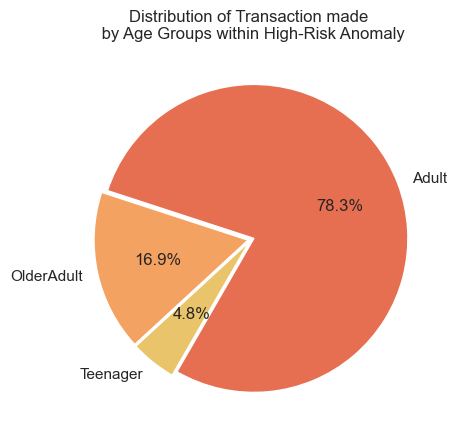

In [58]:
# Count number of records for each combination of Anomalies_Score and AgeGroup
grouped_data = Frau_Monthly_DF.groupby(['Anomalies_Score', 'AgeGroup']).size().reset_index(name='Count')

# Filter for high-risk anomaly score (assuming high-risk is coded as 2)
high_risk_data = grouped_data[grouped_data['Anomalies_Score'] == 2]

# Pie chart for AgeGroup within high-risk
explode = (0.02, 0.02, 0.02)  # Adjust the explode values as per the number of unique AgeGroups
bar_colors2 = ['#e76f51','#f4a261','#e9c46a']

plt.figure(figsize=(5, 5))

plt.pie(high_risk_data['Count'], labels=high_risk_data['AgeGroup'], startangle=-120, autopct='%1.1f%%', colors=bar_colors2, explode=explode)
plt.title('Distribution of Transaction made \n by Age Groups within High-Risk Anomaly')
plt.show()


In [59]:
Frau_Monthly_DF

Customer  Spend_Amt  Repay_Amt Purchase_Date  OverLimit  Repaid  \
0         A1 2716346.13 2670933.38    2004-01-03       True   False   
1         A1   52208.65  117964.43    2004-02-05      False    True   
2         A1  361141.31  187398.64    2004-05-05      False   False   
3         A1  369694.07  165972.88    2005-01-17      False   False   
4         A1  523640.53  662938.23    2005-02-01       True    True   
..       ...        ...        ...           ...        ...     ...   
687      A95  240401.50  369405.96    2004-01-15      False    True   
688      A96   54729.66  310992.30    2004-01-25      False    True   
689      A97  139018.26  121874.90    2004-01-12       True   False   
690      A98  284521.06  337815.57    2004-01-03       True    True   
691      A99   90184.22   25682.73    2004-01-15       True   False   

           City          Type    AgeGroup  max_Tier  count_Spend_Amt  \
0     BANGALORE  TRAIN TICKET  OlderAdult      Gold                9   
1     BANGALORE    BUS TICKET  OlderAdult      Gold                9   
2     BANGALORE    BUS TICKET  OlderAdult      Gold                9   
3     BANGALORE        CAMERA  OlderAdult      Gold                9   
4     BANGALORE  TRAIN TICKET  OlderAdult      Gold                9   
..          ...           ...         ...       ...              ...   
687       PATNA           CAR  OlderAdult      Gold                1   
688     CHENNAI          BIKE       Adult    Silver                1   
689  TRIVANDRUM          AUTO       Adult  Platinum                1   
690    CALCUTTA      SHOPPING       Adult  Platinum                1   
691    CALCUTTA    AIR TICKET       Adult  Platinum                1   

     mean_Spend_Amt  sum_Risk_Group  max_Age    max_Segment    max_City  \
0         571411.42               4       76  Self Employed   BANGALORE   
1         571411.42               4       76  Self Employed   BANGALORE   
2         571411.42               4       76  Self Employed   BANGALORE   
3         571411.42               4       76  Self Employed   BANGALORE   
4         571411.42               4       76  Self Employed   BANGALORE   
..              ...             ...      ...            ...         ...   
687       240401.50               2       62   Salaried_MNC       PATNA   
688        54729.66               2       54   Salaried_Pvt     CHENNAI   
689       139018.26              -2       58           Govt  TRIVANDRUM   
690       284521.06               0       51  Normal Salary    CALCUTTA   
691        90184.22              -2       35  Self Employed    CALCUTTA   

     Membership_Years  Difference_From_Avg  Anomalies  Anomalies_Score  
0                   2           2144934.71       True                2  
1                   2           -519202.77       True                1  
2                   2           -210270.11       True                2  
3                   2           -201717.35       True                2  
4                   2            -47770.89      False                0  
..                ...                  ...        ...              ...  
687                 0                 0.00      False                0  
688                 0                 0.00      False                0  
689                 0                 0.00      False                1  
690                 0                 0.00      False                0  
691                 0                 0.00      False                1  

[692 rows x 20 columns]

## Ideal Number of Cluster

In [60]:
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for. 
# We have it set at 10 right now, but it is completely arbitrary.
cl_num = 15
for i in range (2,cl_num+1):
    kmeans= KMeans(i)
    kmeans.fit(df_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
# wcss

Text(0, 0.5, 'Within-cluster Sum of Squares')

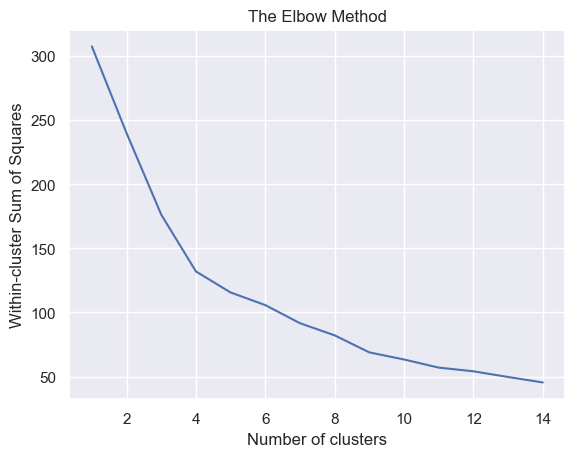

In [61]:

number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')